# Business Case

Handwritten Vs Printed Text Classification

# ML Problem Statement


## Dataset


### Required Libraries and Files

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../TextvsHandWriting"))

Using TensorFlow backend.


['vgg_model.h5', 'Base_CNN_model_Training.ipynb', 'Predition_Using_VGG_weights.ipynb', 'Flask App', 'formsA-D.tgz', 'formsI-Z.tgz', '.DS_Store', 'Data.zip', 'vgg_model_test_500_100_dataset.h5', 'formsA-D', 'vgg16_Model.ipynb', '__pycache__', 'formsI-Z', 'DataSource.rtf', 'model.h5', '.ipynb_checkpoints', 'formsE-H.tgz', 'vgg_model_test_500dataset.h5', 'Data', 'formsE-H', 'DeepCNN.ipynb', 'vgg_model_300dataset.h5']


In [2]:
filenames = os.listdir("Data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'handwritten':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,handwritten.156.jpg,1
1,printed.323.png,0
2,printed.4.PNG,0
3,printed.337.png,0
4,handwritten.195.jpg,1


In [4]:
df.tail()

,filename,category
708,handwritten.167.jpg,1
709,printed.9.PNG,0
710,handwritten.173.jpg,1
711,printed.312.png,0
712,printed.306.png,0


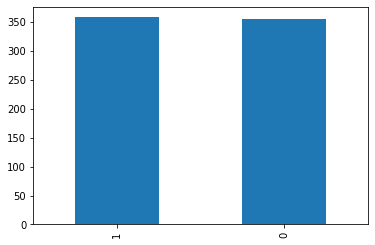

In [5]:
df['category'].value_counts().plot.bar()

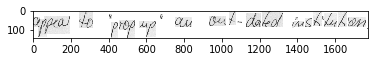

In [6]:
sample = random.choice(filenames)
image = load_img("Data/train/"+sample)
plt.imshow(image)

In [31]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 20
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
df

,filename,category
0,handwritten.156.jpg,1
1,printed.323.png,0
2,printed.4.PNG,0
3,printed.337.png,0
4,handwritten.195.jpg,1
...,...,...
708,handwritten.167.jpg,1
709,printed.9.PNG,0
710,handwritten.173.jpg,1
711,printed.312.png,0


In [9]:
df["category"] = df["category"].replace({0: 'printed', 1: 'handwritten'}) 

In [10]:
df

,filename,category
0,handwritten.156.jpg,handwritten
1,printed.323.png,printed
2,printed.4.PNG,printed
3,printed.337.png,printed
4,handwritten.195.jpg,handwritten
...,...,...
708,handwritten.167.jpg,handwritten
709,printed.9.PNG,printed
710,handwritten.173.jpg,handwritten
711,printed.312.png,printed


In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

In [12]:
train_df

,index,filename,category
0,264,handwritten.55.png,handwritten
1,56,printed.136.PNG,printed
2,204,printed.97.PNG,printed
3,571,handwritten.229.jpg,handwritten
4,527,handwritten.298.png,handwritten
...,...,...,...
565,71,printed.296.png,printed
566,106,.DS_Store,printed
567,270,handwritten.255.png,handwritten
568,435,printed.360.png,printed


In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [14]:
train_df

,index,filename,category
0,264,handwritten.55.png,handwritten
1,56,printed.136.PNG,printed
2,204,printed.97.PNG,printed
3,571,handwritten.229.jpg,handwritten
4,527,handwritten.298.png,handwritten
...,...,...,...
565,71,printed.296.png,printed
566,106,.DS_Store,printed
567,270,handwritten.255.png,handwritten
568,435,printed.360.png,printed


In [15]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Data/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 569 validated image filenames belonging to 2 classes.


/Users/rahul/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [16]:
train_df

,index,filename,category
0,264,handwritten.55.png,handwritten
1,56,printed.136.PNG,printed
2,204,printed.97.PNG,printed
3,571,handwritten.229.jpg,handwritten
4,527,handwritten.298.png,handwritten
...,...,...,...
565,71,printed.296.png,printed
566,106,.DS_Store,printed
567,270,handwritten.255.png,handwritten
568,435,printed.360.png,printed


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Data/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 143 validated image filenames belonging to 2 classes.


In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "Data/train", 
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


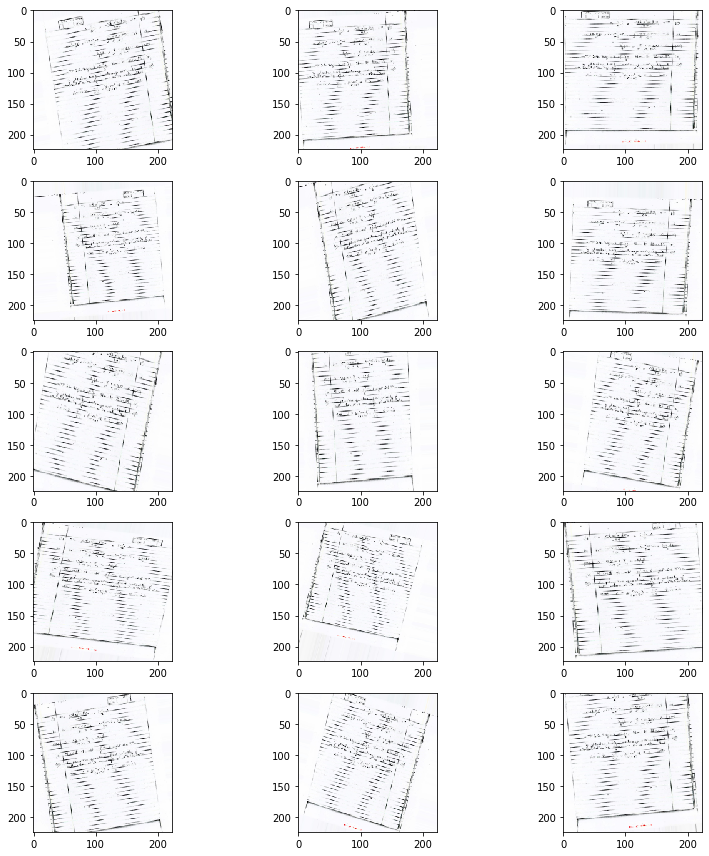

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [32]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/20
35/35 [==============================] - 142s 4s/step - loss: 0.6869 - accuracy: 0.5895 - val_loss: 0.4992 - val_accuracy: 0.9062
Epoch 2/20
35/35 [==============================] - 135s 4s/step - loss: 0.4575 - accuracy: 0.8192 - val_loss: 0.2843 - val_accuracy: 0.9528
Epoch 3/20
35/35 [==============================] - 132s 4s/step - loss: 0.3254 - accuracy: 0.8951 - val_loss: 0.2657 - val_accuracy: 0.9291
Epoch 4/20
35/35 [==============================] - 131s 4s/step - loss: 0.2263 - accuracy: 0.9385 - val_loss: 0.2069 - val_accuracy: 0.9606
Epoch 5/20
35/35 [==============================] - 132s 4s/step - loss: 0.1590 - accuracy: 0.9679 - val_loss: 0.1204 - val_accuracy: 0.9764
Epoch 6/20
35/35 [==============================] - 130s 4s/step - loss: 0.1148 - accuracy: 0.9744 - val_loss: 0.0748 - val_accuracy: 0.9764
Epoch 7/20
35/35 [==============================] - 131s 4s/step - loss: 0.0844 - accuracy: 0.9873 - val_loss: 0.0652 - val_accuracy: 0.9606
Epoch 8/20
35

In [33]:
model.save("vgg_700_98.h5")

In [34]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Validation: accuracy = 0.976562  ;  loss = 0.011941 


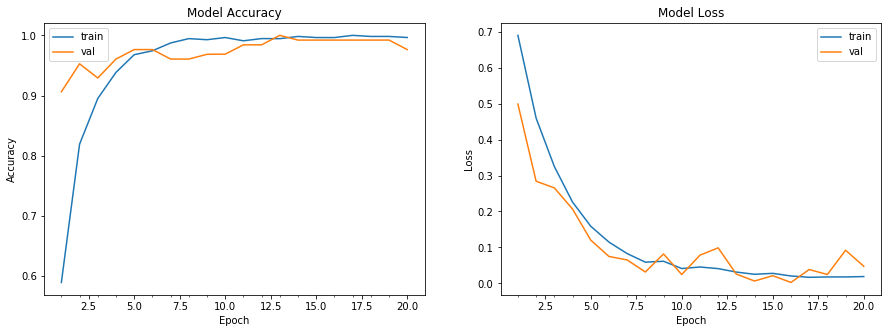

In [35]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [37]:
validate_df["category"] = validate_df["category"].replace({'printed': 0, 'handwritten': 1}) 

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [38]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [39]:
Y_val

0      0
1      1
2      1
3      0
4      1
      ..
138    0
139    1
140    0
141    1
142    0
Name: category, Length: 143, dtype: int64

In [40]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [41]:
y_final.size

143

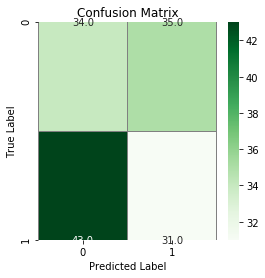

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.44      0.49      0.47        69
           1       0.47      0.42      0.44        74

    accuracy                           0.45       143
   macro avg       0.46      0.46      0.45       143
weighted avg       0.46      0.45      0.45       143



In [31]:
test_filenames = os.listdir("Data/validation")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/validation", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 20 validated image filenames.


In [33]:
test_df

,filename
0,handwritten.142.png
1,handwritten.143.png
2,handwritten.141.png
3,handwritten.140.png
4,printed.142.PNG
5,printed.143.PNG
6,handwritten.144.jpeg
7,printed.141.PNG
8,printed.150.PNG
9,printed.144.PNG


In [34]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [45]:
nb_samples

20

In [35]:
predict

array([[0.15642253],
       [0.1268138 ],
       [0.07409334],
       [0.0769549 ],
       [0.76241887],
       [0.8379706 ],
       [0.3105709 ],
       [0.8402562 ],
       [0.5455879 ],
       [0.79442024],
       [0.77352095],
       [0.19556746],
       [0.70432043],
       [0.55722046],
       [0.6103731 ],
       [0.1590957 ],
       [0.62019664],
       [0.22692771],
       [0.13159972],
       [0.13826606]], dtype=float32)

In [36]:
threshold = 0.5
test_df['category'] = np.where(predict > threshold,1,0)


In [37]:
test_df

,filename,category
0,handwritten.142.png,0
1,handwritten.143.png,0
2,handwritten.141.png,0
3,handwritten.140.png,0
4,printed.142.PNG,1
5,printed.143.PNG,1
6,handwritten.144.jpeg,0
7,printed.141.PNG,1
8,printed.150.PNG,1
9,printed.144.PNG,1


In [38]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [39]:
train_generator.class_indices.items()

dict_items([('handwritten', 0), ('printed', 1)])

In [40]:
test_df

,filename,category
0,handwritten.142.png,handwritten
1,handwritten.143.png,handwritten
2,handwritten.141.png,handwritten
3,handwritten.140.png,handwritten
4,printed.142.PNG,printed
5,printed.143.PNG,printed
6,handwritten.144.jpeg,handwritten
7,printed.141.PNG,printed
8,printed.150.PNG,printed
9,printed.144.PNG,printed


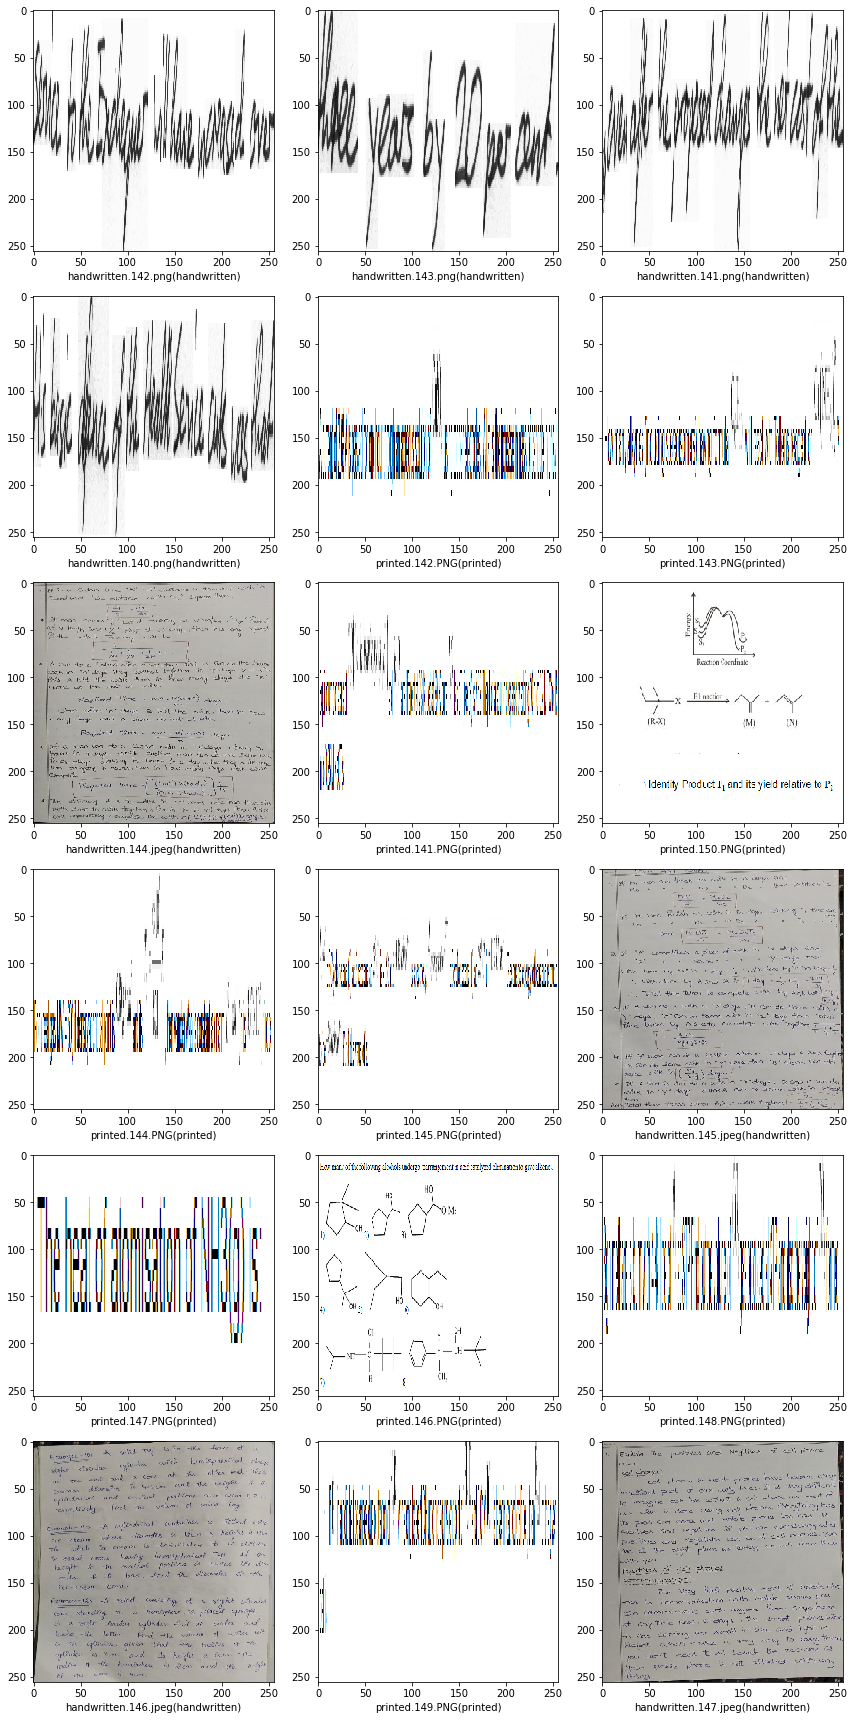

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Data/validation/"+filename, target_size=(256,256))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()